In [1]:
import pandas as pd

meth_path   = "multiomics_meth_beta_values.tsv"
labels_path = "multiomics_labels.tsv"

meth   = pd.read_csv(meth_path, sep="\t")
labels = pd.read_csv(labels_path, sep="\t")

print("Meth shape:", meth.shape)
print("Labels shape:", labels.shape)
meth.head(3)
labels.head(3)

Meth shape: (831, 10001)
Labels shape: (831, 3)


,patient_id,subtype,subtype_simple
0,TCGA-MP-A4SV,TCGA-LUAD,LUAD
1,TCGA-55-8621,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,TCGA-LUAD,LUAD


In [2]:
meth_labeled = meth.merge(labels, on="patient_id")

print("Merged methylation shape:", meth_labeled.shape)
meth_labeled.head(3)

Merged methylation shape: (831, 10003)


,patient_id,cg26841862,cg23057992,cg23091104,cg16602369,cg21164095,cg04571941,cg20545544,cg18703601,cg18121066,...,cg16400631,cg14729148,cg02096296,cg11741189,cg26429499,cg09157320,cg17470497,cg26002259,subtype,subtype_simple
0,TCGA-MP-A4SV,NaN,0.946858,0.977531,0.065308,NaN,0.951136,0.029509,0.079226,0.932836,...,0.557203,0.430219,0.587486,0.310899,0.858140,0.644167,0.429284,0.130573,TCGA-LUAD,LUAD
1,TCGA-55-8621,NaN,0.959341,0.972107,0.928264,NaN,0.952789,0.963493,0.081060,0.858109,...,0.265244,0.549588,0.870886,0.259644,0.933164,0.776085,0.801320,0.151321,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,NaN,0.936614,0.972540,0.089290,NaN,0.067858,0.021693,0.116759,0.771816,...,0.742028,0.791193,0.836851,0.700660,0.950542,0.717134,0.818287,0.657435,TCGA-LUAD,LUAD


In [3]:
# all feature columns = everything except id + labels
cpg_cols = [c for c in meth_labeled.columns
            if c not in ["patient_id", "subtype", "subtype_simple"]]

X_meth_full = meth_labeled[cpg_cols].values
y_str_meth  = meth_labeled["subtype_simple"].values

print("X_meth_full shape:", X_meth_full.shape)
print("First 5 labels:", y_str_meth[:5])

X_meth_full shape: (831, 10000)
First 5 labels: ['LUAD' 'LUAD' 'LUAD' 'LUAD' 'LUAD']


In [4]:
import numpy as np

# Compute variance across samples for each CpG
meth_var = meth_labeled[cpg_cols].var(axis=0)

# Select top 100 most variable CpGs (change 100 → 50/200 as you like)
top_cpgs = meth_var.sort_values(ascending=False).head(100).index.tolist()

print("Number of selected CpGs:", len(top_cpgs))
top_cpgs[:10]

Number of selected CpGs: 100


['cg26841862',
 'cg23057992',
 'cg23091104',
 'cg16602369',
 'cg21164095',
 'cg04571941',
 'cg20545544',
 'cg18703601',
 'cg18121066',
 'cg17520080']

In [5]:
X_meth = X_meth_full

In [6]:
from sklearn.preprocessing import LabelEncoder

le_meth = LabelEncoder()
y_meth = le_meth.fit_transform(y_str_meth)

print("Methylation class mapping:", dict(zip(le_meth.classes_,
                                            le_meth.transform(le_meth.classes_))))

Methylation class mapping: {'LUAD': np.int64(0), 'LUSC': np.int64(1)}


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_meth_train, X_meth_test, y_meth_train, y_meth_test = train_test_split(
    X_meth, y_meth,
    test_size=0.2,
    stratify=y_meth,
    random_state=42
)

scaler_meth = StandardScaler()
X_meth_train_scaled = scaler_meth.fit_transform(X_meth_train)
X_meth_test_scaled  = scaler_meth.transform(X_meth_test)

print("Meth train:", X_meth_train_scaled.shape, "Meth test:", X_meth_test_scaled.shape)

Meth train: (664, 10000) Meth test: (167, 10000)


In [9]:
import numpy as np

print("Total NaNs in full methylation matrix:", np.isnan(X_meth).sum())
print("NaNs in training set:", np.isnan(X_meth_train).sum())
print("NaNs in test set:", np.isnan(X_meth_test).sum())

Total NaNs in full methylation matrix: 659048
NaNs in training set: 526079
NaNs in test set: 132969


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) Train-test split
X_meth_train, X_meth_test, y_meth_train, y_meth_test = train_test_split(
    X_meth, y_meth,
    test_size=0.2,
    stratify=y_meth,
    random_state=42
)

# 2) Impute missing β-values with CpG-wise mean
imputer_meth = SimpleImputer(strategy="mean")
X_meth_train_imp = imputer_meth.fit_transform(X_meth_train)
X_meth_test_imp  = imputer_meth.transform(X_meth_test)

# 3) Scale
scaler_meth = StandardScaler()
X_meth_train_scaled = scaler_meth.fit_transform(X_meth_train_imp)
X_meth_test_scaled  = scaler_meth.transform(X_meth_test_imp)

print("NaNs after imputation – train:", np.isnan(X_meth_train_scaled).sum())
print("NaNs after imputation – test:", np.isnan(X_meth_test_scaled).sum())


NaNs after imputation – train: 0
NaNs after imputation – test: 0


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

logreg_meth = LogisticRegression(
    penalty="l2",
    solver="saga",
    max_iter=5000,
    n_jobs=-1
)

logreg_meth.fit(X_meth_train_scaled, y_meth_train)

y_pred_logreg_meth  = logreg_meth.predict(X_meth_test_scaled)
y_proba_logreg_meth = logreg_meth.predict_proba(X_meth_test_scaled)[:, 1]

acc_logreg_meth = accuracy_score(y_meth_test, y_pred_logreg_meth)
auc_logreg_meth = roc_auc_score(y_meth_test, y_proba_logreg_meth)

print("Methylation Logistic Regression Accuracy:", acc_logreg_meth)
print("Methylation Logistic Regression AUC:", auc_logreg_meth)


Methylation Logistic Regression Accuracy: 0.9700598802395209
Methylation Logistic Regression AUC: 0.9975362318840579



Classification Report (Methylation – Logistic Regression):

              precision    recall  f1-score   support

        LUAD       1.00      0.95      0.97        92
        LUSC       0.94      1.00      0.97        75

    accuracy                           0.97       167
   macro avg       0.97      0.97      0.97       167
weighted avg       0.97      0.97      0.97       167


Confusion Matrix (Methylation – Logistic Regression):
 [[87  5]
 [ 0 75]]


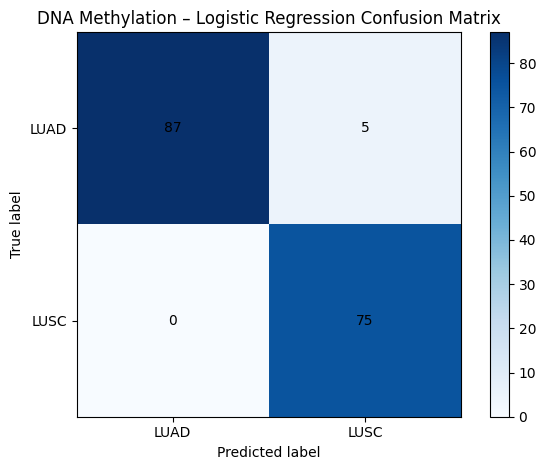

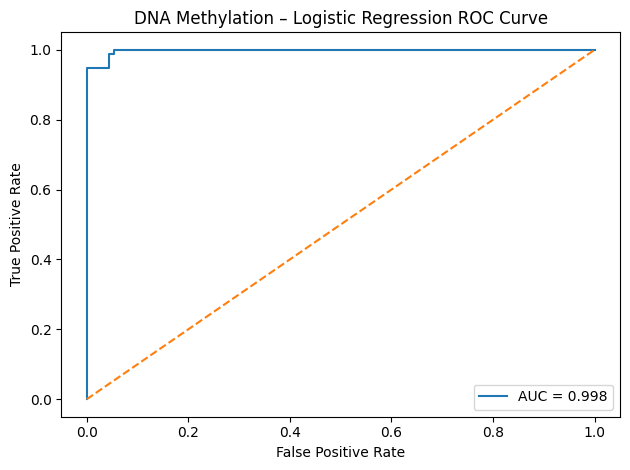

In [13]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import matplotlib.pyplot as plt

# 1) Classification report
print("\nClassification Report (Methylation – Logistic Regression):\n")
print(classification_report(y_meth_test,
                            y_pred_logreg_meth,
                            target_names=le_meth.classes_))

# 2) Confusion matrix
cm_logreg_meth = confusion_matrix(y_meth_test, y_pred_logreg_meth)
print("\nConfusion Matrix (Methylation – Logistic Regression):\n", cm_logreg_meth)

# Optional: simple heatmap-style plot
plt.figure()
plt.imshow(cm_logreg_meth, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], le_meth.classes_)
plt.yticks([0, 1], le_meth.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("DNA Methylation – Logistic Regression Confusion Matrix")
# write counts on cells
for i in range(cm_logreg_meth.shape[0]):
    for j in range(cm_logreg_meth.shape[1]):
        plt.text(j, i, cm_logreg_meth[i, j],
                 ha="center", va="center")
plt.tight_layout()
plt.show()

# 3) ROC curve + AUC
auc_logreg_meth = roc_auc_score(y_meth_test, y_proba_logreg_meth)
fpr, tpr, _ = roc_curve(y_meth_test, y_proba_logreg_meth)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_logreg_meth:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DNA Methylation – Logistic Regression ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


# LDA

Linear Discriminant Analysis 
- Assumes each class (LUAD, LUSC) has a **multivariate Gaussian** distribution
- Assumes both classes share the **same covariance matrix**
- Finds a linear projection (a weighted sum of CpG $\beta$-values) that maximizes the separation between LUAD and LUSC means while minimizing within-class variance

"What linear combination of CpG methylation values best separates LUAD from LUSC"

#### Train LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_meth = LinearDiscriminantAnalysis()
lda_meth.fit(X_meth_train_scaled, y_meth_train)


,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


#### Predict and fet Probabilities

In [15]:
y_pred_lda_meth = lda_meth.predict(X_meth_test_scaled)
y_proba_lda_meth = lda_meth.predict_proba(X_meth_test_scaled)[:, 1]  

#### Evaluation

In [16]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

acc_lda_meth = accuracy_score(y_meth_test, y_pred_lda_meth)
print("Methylation LDA Accuracy:", acc_lda_meth)

print("\nClassification Report (Methylation – LDA):\n")
print(classification_report(y_meth_test,
                            y_pred_lda_meth,
                            target_names=le_meth.classes_))

cm_lda_meth = confusion_matrix(y_meth_test, y_pred_lda_meth)
print("\nConfusion Matrix (Methylation – LDA):\n", cm_lda_meth)


Methylation LDA Accuracy: 0.9640718562874252

Classification Report (Methylation – LDA):

              precision    recall  f1-score   support

        LUAD       0.99      0.95      0.97        92
        LUSC       0.94      0.99      0.96        75

    accuracy                           0.96       167
   macro avg       0.96      0.97      0.96       167
weighted avg       0.97      0.96      0.96       167


Confusion Matrix (Methylation – LDA):
 [[87  5]
 [ 1 74]]


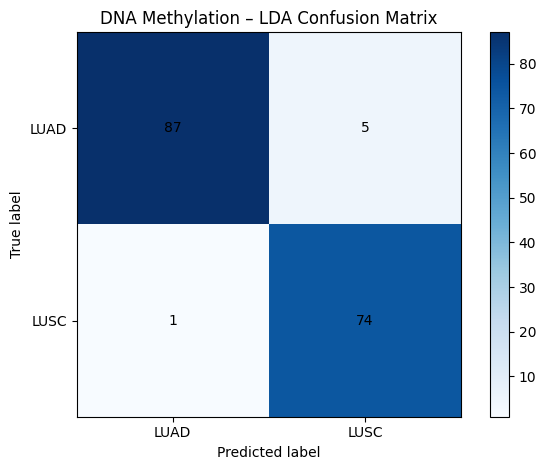

In [17]:
plt.figure()
plt.imshow(cm_lda_meth, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], le_meth.classes_)
plt.yticks([0, 1], le_meth.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("DNA Methylation – LDA Confusion Matrix")

for i in range(cm_lda_meth.shape[0]):
    for j in range(cm_lda_meth.shape[1]):
        plt.text(j, i, cm_lda_meth[i, j],
                 ha="center", va="center")
plt.tight_layout()
plt.show()


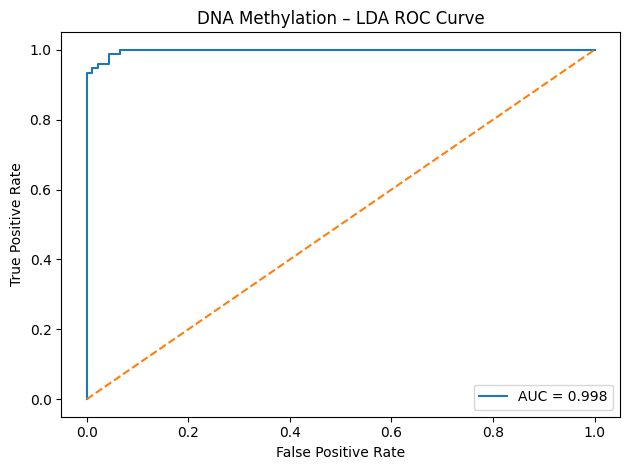

In [18]:
auc_lda_meth = roc_auc_score(y_meth_test, y_proba_lda_meth)
fpr, tpr, _ = roc_curve(y_meth_test, y_proba_lda_meth)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_lda_meth:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DNA Methylation – LDA ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


# KNN

Methylation KNN Accuracy: 0.9520958083832335
Methylation KNN AUC: 0.9794202898550725
              precision    recall  f1-score   support

        LUAD       0.99      0.92      0.96        92
        LUSC       0.91      0.99      0.95        75

    accuracy                           0.95       167
   macro avg       0.95      0.96      0.95       167
weighted avg       0.95      0.95      0.95       167

[[85  7]
 [ 1 74]]


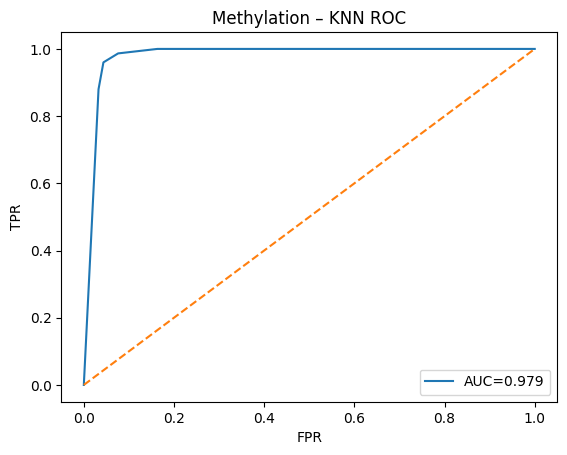

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train model
knn_meth = KNeighborsClassifier(n_neighbors=5)
knn_meth.fit(X_meth_train_scaled, y_meth_train)

# Predictions
y_pred_knn_meth  = knn_meth.predict(X_meth_test_scaled)
y_proba_knn_meth = knn_meth.predict_proba(X_meth_test_scaled)[:, 1]

# Metrics
acc_knn_meth = accuracy_score(y_meth_test, y_pred_knn_meth)
auc_knn_meth = roc_auc_score(y_meth_test, y_proba_knn_meth)

print("Methylation KNN Accuracy:", acc_knn_meth)
print("Methylation KNN AUC:", auc_knn_meth)
print(classification_report(y_meth_test, y_pred_knn_meth, target_names=le_meth.classes_))

# Confusion Matrix
cm_knn_meth = confusion_matrix(y_meth_test, y_pred_knn_meth)
print(cm_knn_meth)

# ROC Curve
fpr, tpr, _ = roc_curve(y_meth_test, y_proba_knn_meth)
plt.plot(fpr, tpr, label=f"AUC={auc_knn_meth:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("Methylation – KNN ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


# Naive Bayes

Methylation NB Accuracy: 0.9161676646706587
Methylation NB AUC: 0.9239855072463768
              precision    recall  f1-score   support

        LUAD       0.91      0.95      0.93        92
        LUSC       0.93      0.88      0.90        75

    accuracy                           0.92       167
   macro avg       0.92      0.91      0.91       167
weighted avg       0.92      0.92      0.92       167

[[87  5]
 [ 9 66]]


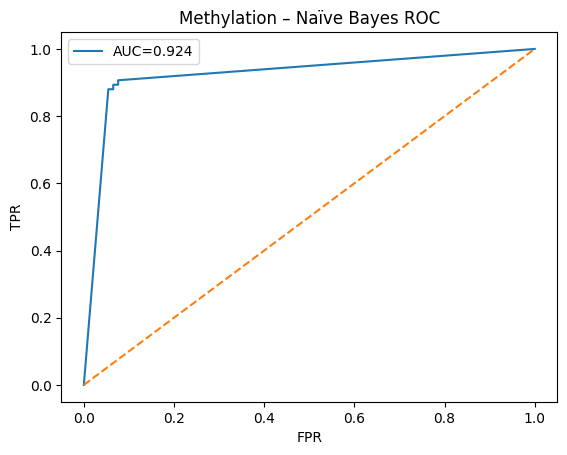

In [20]:
from sklearn.naive_bayes import GaussianNB

nb_meth = GaussianNB()
nb_meth.fit(X_meth_train_scaled, y_meth_train)

y_pred_nb_meth  = nb_meth.predict(X_meth_test_scaled)
y_proba_nb_meth = nb_meth.predict_proba(X_meth_test_scaled)[:, 1]

acc_nb_meth = accuracy_score(y_meth_test, y_pred_nb_meth)
auc_nb_meth = roc_auc_score(y_meth_test, y_proba_nb_meth)

print("Methylation NB Accuracy:", acc_nb_meth)
print("Methylation NB AUC:", auc_nb_meth)
print(classification_report(y_meth_test, y_pred_nb_meth, target_names=le_meth.classes_))

cm_nb_meth = confusion_matrix(y_meth_test, y_pred_nb_meth)
print(cm_nb_meth)

fpr, tpr, _ = roc_curve(y_meth_test, y_proba_nb_meth)
plt.plot(fpr, tpr, label=f"AUC={auc_nb_meth:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("Methylation – Naïve Bayes ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


# Decision Tree CART

Methylation DT Accuracy: 0.9341317365269461
Methylation DT AUC: 0.9223913043478262
              precision    recall  f1-score   support

        LUAD       0.94      0.95      0.94        92
        LUSC       0.93      0.92      0.93        75

    accuracy                           0.93       167
   macro avg       0.93      0.93      0.93       167
weighted avg       0.93      0.93      0.93       167

[[87  5]
 [ 6 69]]


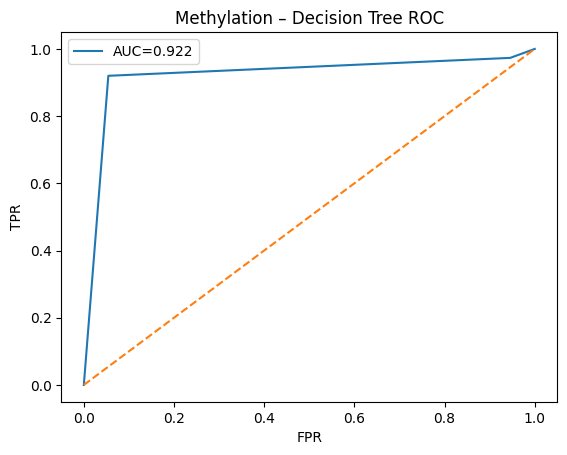

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_meth = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_meth.fit(X_meth_train_scaled, y_meth_train)

y_pred_dt_meth  = dt_meth.predict(X_meth_test_scaled)
y_proba_dt_meth = dt_meth.predict_proba(X_meth_test_scaled)[:, 1]

acc_dt_meth = accuracy_score(y_meth_test, y_pred_dt_meth)
auc_dt_meth = roc_auc_score(y_meth_test, y_proba_dt_meth)

print("Methylation DT Accuracy:", acc_dt_meth)
print("Methylation DT AUC:", auc_dt_meth)
print(classification_report(y_meth_test, y_pred_dt_meth, target_names=le_meth.classes_))

cm_dt_meth = confusion_matrix(y_meth_test, y_pred_dt_meth)
print(cm_dt_meth)

fpr, tpr, _ = roc_curve(y_meth_test, y_proba_dt_meth)
plt.plot(fpr, tpr, label=f"AUC={auc_dt_meth:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("Methylation – Decision Tree ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# SVM

Methylation SVM Accuracy: 0.9700598802395209
Methylation SVM AUC: 0.9950724637681159
              precision    recall  f1-score   support

        LUAD       1.00      0.95      0.97        92
        LUSC       0.94      1.00      0.97        75

    accuracy                           0.97       167
   macro avg       0.97      0.97      0.97       167
weighted avg       0.97      0.97      0.97       167

[[87  5]
 [ 0 75]]


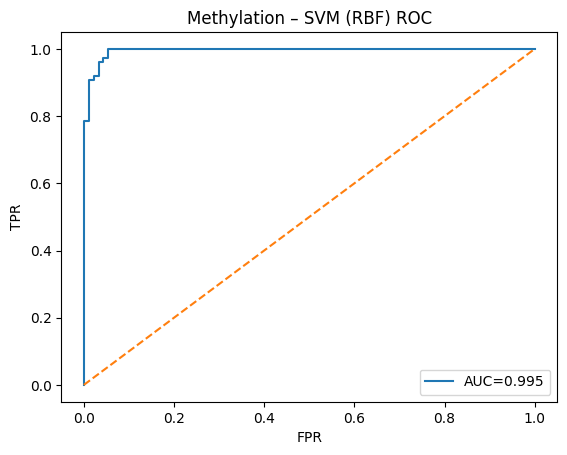

In [22]:
from sklearn.svm import SVC

svm_meth = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
svm_meth.fit(X_meth_train_scaled, y_meth_train)

y_pred_svm_meth  = svm_meth.predict(X_meth_test_scaled)
y_proba_svm_meth = svm_meth.predict_proba(X_meth_test_scaled)[:, 1]

acc_svm_meth = accuracy_score(y_meth_test, y_pred_svm_meth)
auc_svm_meth = roc_auc_score(y_meth_test, y_proba_svm_meth)

print("Methylation SVM Accuracy:", acc_svm_meth)
print("Methylation SVM AUC:", auc_svm_meth)
print(classification_report(y_meth_test, y_pred_svm_meth, target_names=le_meth.classes_))

cm_svm_meth = confusion_matrix(y_meth_test, y_pred_svm_meth)
print(cm_svm_meth)

fpr, tpr, _ = roc_curve(y_meth_test, y_proba_svm_meth)
plt.plot(fpr, tpr, label=f"AUC={auc_svm_meth:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("Methylation – SVM (RBF) ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [23]:
import pandas as pd

meth_results = [
    {"Model": "LDA",                 "Accuracy": acc_lda_meth,      "AUC": auc_lda_meth},
    {"Model": "KNN (k=5)",           "Accuracy": acc_knn_meth,      "AUC": auc_knn_meth},
    {"Model": "Naive Bayes",         "Accuracy": acc_nb_meth,       "AUC": auc_nb_meth},
    {"Model": "Decision Tree (CART)","Accuracy": acc_dt_meth,       "AUC": auc_dt_meth},
    {"Model": "SVM (RBF)",           "Accuracy": acc_svm_meth,      "AUC": auc_svm_meth},
    {"Model": "Logistic Regression", "Accuracy": acc_logreg_meth,   "AUC": auc_logreg_meth},
]

meth_summary = pd.DataFrame(meth_results)
meth_summary = meth_summary.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

meth_summary


,Model,Accuracy,AUC
0,SVM (RBF),0.970060,0.995072
1,Logistic Regression,0.970060,0.997536
2,LDA,0.964072,0.997536
3,KNN (k=5),0.952096,0.979420
4,Decision Tree (CART),0.934132,0.922391
5,Naive Bayes,0.916168,0.923986


In [24]:
meth_summary_round = meth_summary.copy()
meth_summary_round["Accuracy"] = meth_summary_round["Accuracy"].round(3)
meth_summary_round["AUC"]      = meth_summary_round["AUC"].round(3)

print(meth_summary_round.to_markdown(index=False))


| Model                |   Accuracy |   AUC |
|:---------------------|-----------:|------:|
| SVM (RBF)            |      0.97  | 0.995 |
| Logistic Regression  |      0.97  | 0.998 |
| LDA                  |      0.964 | 0.998 |
| KNN (k=5)            |      0.952 | 0.979 |
| Decision Tree (CART) |      0.934 | 0.922 |
| Naive Bayes          |      0.916 | 0.924 |


In [25]:
meth_summary_round.to_csv("methylation_unimodal_results.csv", index=False)

with open("methylation_unimodal_results.tex", "w") as f:
    f.write(meth_summary_round.to_latex(index=False))
